Import the required libraries.

In [1]:
import itertools, os
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

##### Create a python class to handle data files containing MD descriptor frames.

In [2]:
class MDframes_DL:
    def __init__(self):
        self.MDQSAR_directory = "MD_Data/"
        self.retrieve_data_labels()
        self.retrieve_cpd_filenames()
        
    def retrieve_data_labels(self):
        '''Retrieve the names of compounds along with binding affinities and save them in dictionary.'''
        cpd_affmanager = open("aff.csv",'r')
        cpd_affmanager.readline()
        self.cpd_data_labels = {i[0]:float(i[1]) for i in (x.strip().split(',') for x in cpd_affmanager)} # make dictionary of compound IDs (string) matched with binding affinities (float)
        
    def retrieve_cpd_filenames(self):
        '''Retrieve the names of all cpds files in the folder and shuffle the list.'''
        self.cpd_filenames = os.listdir(self.MDQSAR_directory) # contains the names of all compounds in the folder
        shuffle(self.cpd_filenames)
        
    def BatchGenerator(self,file_names):
        "Based on files in path and generate data and labels batch by batch."
        initial = 0
        batch_size = 1
        while initial < len(file_names):
            pre_data = []
            labels = []
            for i in range(batch_size):
                if initial < len(file_names):
                    if os.path.isfile(self.MDQSAR_directory+file_names[initial]): 
                        each_cpd = pd.read_csv(self.MDQSAR_directory+file_names[initial]).astype(float)
                        df = each_cpd.fillna(0)
                        scaler = MinMaxScaler()
                        each_cpd_scaled = scaler.fit_transform(df)
                        pre_data.append(each_cpd_scaled)
                        labels.append(self.cpd_data_labels[file_names[initial][:-4]])
                        initial += 1
            pre_data = np.nan_to_num(np.array(pre_data))
            shaped_data = pre_data.reshape((pre_data.shape[0], pre_data.shape[1] * pre_data.shape[2]))
            scaler = MinMaxScaler(feature_range=(0, 1))
            final_data = scaler.fit_transform(shaped_data)
            yield final_data, labels
      
    def read_data(self, files):
        '''
        Given a list of file names, extract the descriptors. 
        Fill missing values with zeros, scale the data from zero to 1 column by column. 
        Return the processed data and the endpoints (in other words, labels).
        '''
        pre_data = []
        labels = []
        for i in files:
            each_cpd = pd.read_csv(self.MDQSAR_directory+i,engine='python').astype(float)
            df = each_cpd.fillna(0)
            scaler = preprocessing.MinMaxScaler()
            each_cpd_scaled = scaler.fit_transform(df)
            pre_data.append(each_cpd_scaled)
            labels.append(self.cpd_data_labels[i[:-4]])
        pre_data = np.nan_to_num(np.array(pre_data))
        shaped_data = pre_data.reshape((pre_data.shape[0], pre_data.shape[1] * pre_data.shape[2]))
        scaler = preprocessing.MinMaxScaler()
        data = scaler.fit_transform(shaped_data)
        return data, labels
    
    def split_partitions(self, filenames, folds):
        '''
        The following function splits the data into k different folds, given a list of compound names and the number of partitions.
        There will be two outputs: one folds (test sets) and k-1 folds (train sets). 
        '''
        num_val_samples = len(filenames) // folds+1
        one_fold = []
        nine_folds = []
        for i in range(folds):
            one_fold_data = filenames[i * num_val_samples: (i + 1) * num_val_samples] # prepares the validation data: data from partition # k
            one_fold.append(one_fold_data)
            
            nine_fold_data = np.concatenate([filenames[:i * num_val_samples],filenames[(i + 1) * num_val_samples:]],axis=0).tolist() # prepares the training data: data from all other partitions
            nine_folds.append(nine_fold_data)
        return one_fold, nine_folds 
      

In [3]:
# Get a list of cpd file names in the MD_Data directory.

directory = "MD_Data/"
cpd_files     = os.listdir(directory)

# Shuffle the names of the cpd files.
cpd_files = shuffle(cpd_files, random_state=65)
print(cpd_files)

['CHEMBL3689722.csv', 'CHEMBL3689625.csv', 'CHEMBL3689656.csv', 'CHEMBL3689646.csv', 'CHEMBL3689664.csv', 'CHEMBL3689648.csv', 'CHEMBL3689672.csv', 'CHEMBL3689705.csv', 'CHEMBL3689713.csv', 'CHEMBL3690082.csv', 'CHEMBL3689693.csv', 'CHEMBL3689737.csv', 'CHEMBL3689663.csv', 'CHEMBL3690077.csv', 'CHEMBL3689597.csv', 'CHEMBL3689603.csv', 'CHEMBL3689616.csv', 'CHEMBL3689697.csv', 'CHEMBL3689662.csv', 'CHEMBL3689614.csv', 'CHEMBL3689677.csv', 'CHEMBL3689708.csv', 'CHEMBL3689704.csv', 'CHEMBL3689749.csv', 'CHEMBL3689682.csv', 'CHEMBL3689666.csv', 'CHEMBL3689612.csv', 'CHEMBL3689716.csv', 'CHEMBL3689659.csv', 'CHEMBL3689633.csv', 'CHEMBL3689618.csv', 'CHEMBL3689622.csv', 'CHEMBL3689684.csv', 'CHEMBL3689710.csv', 'CHEMBL3689686.csv', 'CHEMBL3689738.csv', 'CHEMBL3689627.csv', 'CHEMBL3689606.csv', 'CHEMBL3690076.csv', 'CHEMBL3689611.csv', 'CHEMBL3689703.csv', 'CHEMBL3689632.csv', 'CHEMBL3689615.csv', 'CHEMBL3689706.csv', 'CHEMBL3689723.csv', 'CHEMBL3689735.csv', 'CHEMBL3689653.csv', 'CHEMBL36897

In [7]:
outer_k = 5

sample = MDframes_DL()
test_fold, train_fold = sample.split_partitions(cpd_files, outer_k)

In [8]:
len(test_fold[0]), len(train_fold[0])

(35, 135)

Perform k-fold CV with RF algorithm. 

In [10]:
outerCV_targets = []
outerCV_predictions = []
outerCV_IDs = [] 

for i in range(outer_k):

    outer_train = train_fold[i]
    outer_test  = test_fold[i]
    
    outerCV_test_data, outerCV_test_targets = sample.read_data(outer_test)
    outerCV_train_data, outerCV_train_targets = sample.read_data(outer_train)
    
    cv_rf = RandomForestRegressor(n_estimators= 100, 
                                  max_depth = 5, 
                                  max_features = 'auto', 
                                  min_samples_leaf = 1, 
                                  min_samples_split = 5,
                                  bootstrap = True, 
                                  criterion="mae", 
                                  n_jobs = -1)
    # Fit the random search model
    cv_rf.fit(outerCV_train_data,outerCV_train_targets)

    outerCV_test_predictions = cv_rf.predict(outerCV_test_data).tolist()
    outerCV_predictions.append(outerCV_test_predictions)
    outerCV_targets.append(outerCV_test_targets)
    outerCV_IDs.append(outer_test)
    

In [12]:
outerCV_targets_combined  = list(itertools.chain.from_iterable(outerCV_targets))
outerCV_predictions_combined = list(itertools.chain.from_iterable(outerCV_predictions))
outerCV_IDs_combined = list(itertools.chain.from_iterable(outerCV_IDs))

In [16]:
rms = mean_squared_error(outerCV_targets_combined, outerCV_predictions_combined, squared=False)
print(f"rms error is: {rms:.2f}")

r2 = r2_score(outerCV_targets_combined, outerCV_predictions_combined)
print(f"r2 value is: {r2:.2f}")

rms error is: 0.88
r2 value is: 0.07


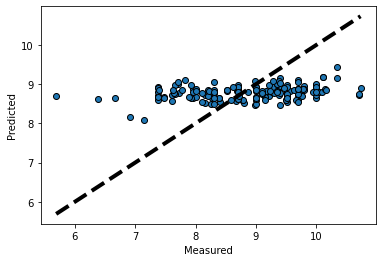

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = outerCV_targets_combined
ax.scatter(x, outerCV_predictions_combined, edgecolors=(0,0,0))
ax.plot([min(x), max(x)],[min(x), max(x)],'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.rcParams["figure.dpi"] = 300
plt.show()

In [ ]:
outerCV_targets_combined  = list(itertools.chain.from_iterable(outerCV_targets))
outerCV_predictions_combined = list(itertools.chain.from_iterable(outerCV_predictions))
outerCV_IDs_combined = list(itertools.chain.from_iterable(outerCV_IDs))

cv_frame = pd.DataFrame()
cv_frame['IDs'] = outerCV_IDs_combined
cv_frame['ExperimentalAff'] = outerCV_targets_combined
cv_frame['PredictedAff'] = outerCV_predictions_combined

cv_frame.to_csv(directory+'RF_CV_BestModel_Predictions.csv',index=False)